<a href="https://colab.research.google.com/github/pritiyadav888/Machine-Learning-Projects/blob/main/face_mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Priti Yadav


Loading the dataset

In [ ]:
# !pip3 install --user --upgrade tensorflow  # install in $HOME

In [ ]:
# !pip install imutils

In [ ]:
# !pip install opencv-python

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import gc   #garbage collector interface
import cv2

In [ ]:
# !pip install Pillow

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
LR = 1e-2
EPOCHS = 5
Batch_Size = 64
CATEGORIES = ["with_mask", "without_mask"]

<b>Data Processing<b>

In [ ]:
data = []
labels = []
image_path = []

import pandas as pd
from collections import Counter

for category in CATEGORIES:
    data_path = os.path.join("Dataset", category)
    for img in os.listdir(data_path):
        img_path = os.path.join(data_path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)
        df = pd.DataFrame({'image_path': img_path,'lable': labels,'data': data})  
        

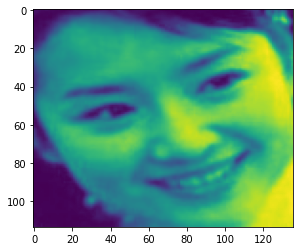

In [ ]:
## Choosing the image from the directory
img = cv2.imread("Dataset/without_mask/5431.jpg")
## Converting the image to grayscale to apply algorithm
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig = plt.imshow(img)

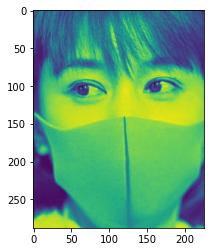

In [ ]:
## Choosing the image from the directory
img = cv2.imread("Dataset/with_mask/4515.jpg")
## Converting the image to grayscale to apply algorithm
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig = plt.imshow(img)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  11042 non-null  object
 1   lable       11042 non-null  object
 2   data        11042 non-null  object
dtypes: object(3)
memory usage: 258.9+ KB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


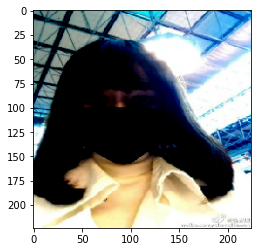

In [ ]:
fig = plt.imshow(data[90])

In [ ]:
df.lable.value_counts()

with_mask       5521
without_mask    5521
Name: lable, dtype: int64

With Mask: 5521
Without Mask: 5521


<AxesSubplot:xlabel='lable', ylabel='count'>

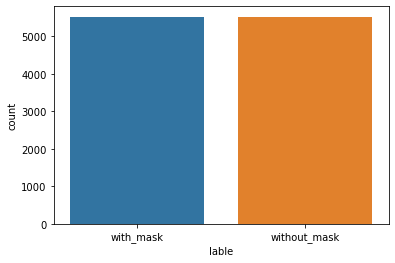

In [ ]:
## Checking for total number of images in the dataset
import seaborn as sns
print(f"With Mask:", df.value_counts("lable")[0])
print(f"Without Mask:", df.value_counts("lable")[1])

## Plotting the numbers
sns.countplot(x = df["lable"])

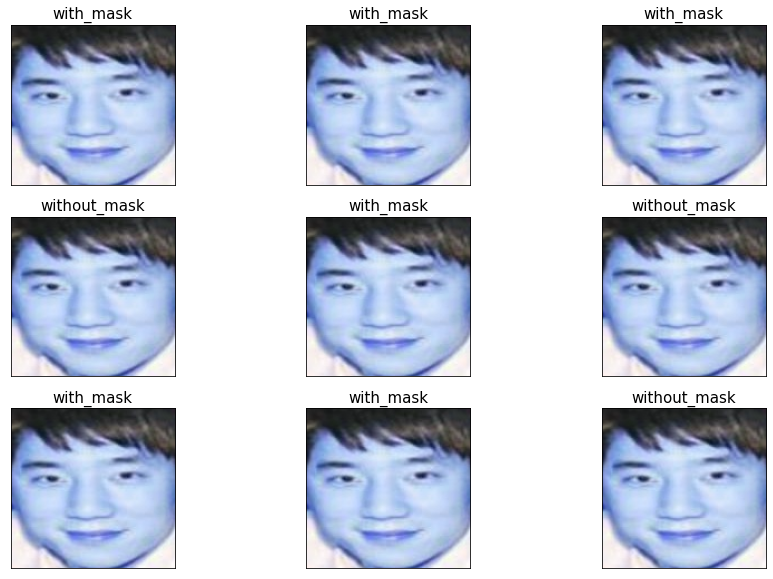

In [ ]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(df))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(df.loc[random,"image_path"]))
    plt.title(df.loc[random,"lable"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
gc.collect()
gc.get_count()

(16, 0, 0)

In [ ]:
# perform one-hot encoding on the labels
one_hot = LabelBinarizer()
labels = one_hot.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.10, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# # load the MobileNetV2 network, rescaling

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(220, 220, 3)))

# construct the head of the model that will be placed on top of the
# the base model
model = baseModel.output
model = MaxPooling2D(pool_size=(3, 3))(model)
model = Dense(200, activation="relu")(model)
model = Flatten(name="flatten")(model)
model = Dense(64, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=model)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:layer.trainable = False

# compile our model
print("compiling model")
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("training head")
Head = model.fit(
    aug.flow(trainX, trainY, batch_size=Batch_Size),
    steps_per_epoch=len(trainX) // Batch_Size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // Batch_Size,epochs=EPOCHS)



2022-03-24 23:55:35.073853: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


compiling model
training head
Epoch 1/5
155/155 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.9599

ValueError: in user code:

    File "/Users/priti/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "/Users/priti/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/priti/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "/Users/priti/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "/Users/priti/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/priti/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 220, 220, 3), found shape=(65, 224, 224, 3)


In [ ]:
#Let's check the memory usage
memory_usage()

In [ ]:
gc.collect()
gc.get_count()

In [ ]:
model.summary()

In [ ]:
# make predictions on the testing set
print("Evaluating network...")
predIdxs = model.predict(testX, batch_size=Batch_Size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
target_names=lb.classes_))

# serialize the model to disk
print("Saving mask detector model...")
model.save("mask_detector.model", save_format="h5")
